# Chapter 20 - Auto Machine Learning
# Exercises solutions
# ===========================================   

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [6]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

In [14]:
df = pd.read_csv('https://raw.githubusercontent.com/tweyde/binder-test/main/data/credit-g.csv')

In [15]:
#take a look at the first rows of the dataframe 
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [ ]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")

# one hot encodings
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine Dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function, to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... Make sure type is good. We change the type from str to numeric here.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

# display cleaned dataframe
df.head()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,22,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0


## Divide DataSet: Training, Testing, Cross-validation
We will use an additional separation of our dataset for cross-validation for AutoML pipeline selection. Training data will be used for training models as usual, cross-validation data (which is held back from the training data) will be used to judge the performance of the models and pipelines selected.

Testing data we will only use for testing the final models that result from each approach so as we can judge the relative performance of each. How well will the full blown AutoML do out-of-sample?

In [ ]:
from sklearn.model_selection import train_test_split

# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

#>>> Extract validation set from the training data... <<<
X_train, X_cross_validation, y_train, y_cross_validation = train_test_split(X_train, y_train, test_size=0.3, random_state=None)

AutoML has several stages, principally pre-processing and model selection. We run through these stages using a limited automation process of our own, for the credit use-case.  

## Stage1: Pre-processing

Several techniques can be used to preprocess data. Here we have a simple classification problem and we address the imbalances in the dataset. There are more samples of one class than the other, so we will use SMOTE to create synthetic samples to allow us to up-sample and balance the dataset.
Full blown AutoML, we will see later, needs to deal with preprocessing and uses meta-learning to determine how to do this. <br>

Get the sklearn packages we will need for our clasification problem.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier   
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

We can wrap data-preprocessing into a single function, where SMOTE is used to balance the classes in the dataset, and we can scale the data too.

In [ ]:
# import SMOTE object
from imblearn.over_sampling import SMOTE

# Wrap up balancing the dataset by up-sammpling using SMOTE, then scaling the data for the training stage.
def data_preprocess(X_train, y_train, X_cross_validation) -> (np.array, np.array, np.array):
  #Balance training data....
  # Generate SMOTE samples and use this to train
  upsampler_smote = SMOTE()
  X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

  sclr = StandardScaler()
  sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data:
  # scale both sets:
  X_train = sclr.transform(X_upsampled_smote) 
  X_cross_validation = sclr.transform(X_cross_validation)
  
  y_train = y_upsampled_smote
  
  return X_train, y_train, X_cross_validation

#Get the data in shape
X_train, y_train, X_cross_validation = data_preprocess(X_train, y_train, X_cross_validation)
print(f'X_train mean: {X_train.mean():.4f} - std: {X_train.std():.4f}')
print(f'X_cross_validation mean: {X_cross_validation.mean():.4f} - std: {X_cross_validation.std():.4f}')
print(f'y_train mean: {y_train.mean():.4f} - std: {y_train.std():.4f}')


X_train mean: -0.0731 - std: 0.9371
X_cross_validation mean: -0.0164 - std: 0.9660
y_train mean: 0.5000 - std: 0.5003


## Exercise 1

Run our model selection function auto_classifier_selection. Which model is the best performing?

DecisionTreeClassifier(max_depth=5)
F1 train: 0.8485, F1 cross-validation:  0.5417

GaussianNB()
F1 train: 0.8123, F1 cross-validation:  0.4231

LogisticRegression(max_iter=2000, random_state=0)
F1 train: 0.8436, F1 cross-validation:  0.1333

MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
F1 train: 0.8293, F1 cross-validation:  0.3871

RandomForestClassifier(max_depth=3, random_state=0)
F1 train: 0.8263, F1 cross-validation:  0.4882

LinearDiscriminantAnalysis()
F1 train: 0.8455, F1 cross-validation:  0.2703


Winner
DecisionTreeClassifier(max_depth=5) 

Accuracy train: 0.8288, Accuracy cross-validation:  0.6750
Precision train: 0.9144, Precision cross-validation:  0.8636
Recall train: 0.7365, Recall cross-validation:  0.6552
F1 train: 0.8485, F1 cross-validation:  0.5517 



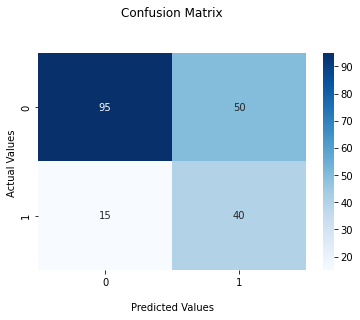

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, y_cross_validation: pd.DataFrame) -> (list, list):
    
    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.transform(X_cross_validation)
    
    # initialise all the models to run
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0)
    lda = LinearDiscriminantAnalysis()
    
    # store all the models in a list
    all_mdls = [dtc,gnb,lr,mlp,rf, lda]
    
    #Find the best
    max_f1 = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        
        # Output model selection information....
        print(mdl)
        print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, F1 cross-validation: ",
        f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}\n")
        
        #F1...
        this_f1 = f1_score(y_upsampled_smote,y_train_hat, average=None)[1]
        if this_f1 > max_f1:
            max_f1 = this_f1
            max_mdl = mdl
        
    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner')  
    print(max_mdl, '\n')      
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, Accuracy cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, Precision cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, Recall cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, F1 cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}", '\n')
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    return max_mdl, all_mdls

#Run our function....autoselect the best classifier wrt F1
max_mdl, all_models = auto_classifier_selection(X_train, X_cross_validation, y_train, y_cross_validation)

## Exercise 2

However, we care more about getting a “bad credit flag” wrong as the cost of a bad credit is high. Alter the function *auto_classifier_selection* to select models based on **precision** rather than F1 score. Which model is best performing? 

DecisionTreeClassifier(max_depth=5)
Precision train: 0.7794, Precision cross-validation:  0.4505

GaussianNB()
Precision train: 0.8144, Precision cross-validation:  0.4490

LogisticRegression(max_iter=2000, random_state=0)
Precision train: 0.8797, Precision cross-validation:  0.8000

MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
Precision train: 0.8213, Precision cross-validation:  0.4737

RandomForestClassifier(max_depth=3, random_state=0)
Precision train: 0.8042, Precision cross-validation:  0.4306

LinearDiscriminantAnalysis()
Precision train: 0.8780, Precision cross-validation:  0.5263


Winner:
LogisticRegression(max_iter=2000, random_state=0) 

Accuracy train: 0.7956, Accuracy cross-validation:  0.7400
Precision train: 0.8242, Precision cross-validation:  0.7385
Recall train: 0.8892, Recall cross-validation:  0.9931
F1 train: 0.8436, F1 cross-validation:  0.1333 



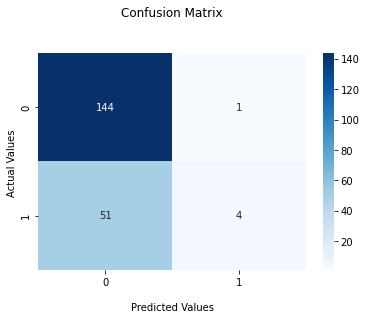

In [ ]:
# ignore system warnings (warnings are not errors)
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, y_cross_validation: pd.DataFrame) -> (list, list):
    
    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.transform(X_cross_validation)
    
    # initialise all the models to run
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0)
    lda = LinearDiscriminantAnalysis()
    
    # store all the models in a list
    all_mdls = [dtc,gnb,lr,mlp,rf, lda]
    
    #Find the best
    max_precision = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        
        # Output model selection information....
        print(mdl)
        print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, Precision cross-validation: ",
        f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}\n")
        
        #F1...
        this_precision = precision_score(y_upsampled_smote,y_train_hat, average=None)[1]
        if this_precision > max_precision:
            max_precision = this_precision
            max_mdl = mdl
        
    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner:')  
    print(max_mdl, '\n')      
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, Accuracy cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, Precision cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, Recall cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, F1 cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}", '\n')
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    return max_mdl, all_mdls

#Run our function....autoselect the best classifier wrt F1
max_mdl, all_models = auto_classifier_selection(X_train, X_cross_validation, y_train, y_cross_validation)

## Exercise 3

However, we care more about getting a “bad credit flag” wrong as the cost of a bad credit is high. Alter the function *auto_classifier_selection* to select models based on **recall** rather than F1 score. Which model is best performing?

DecisionTreeClassifier(max_depth=5)
Recall train: 0.9310, Recall cross-validation:  0.7273

GaussianNB()
Recall train: 0.8103, Recall cross-validation:  0.4000

LogisticRegression(max_iter=2000, random_state=0)
Recall train: 0.8103, Recall cross-validation:  0.0727

MLPClassifier(early_stopping=True, max_iter=2000, random_state=1)
Recall train: 0.8374, Recall cross-validation:  0.3273

RandomForestClassifier(max_depth=3, random_state=0)
Recall train: 0.8498, Recall cross-validation:  0.5636

LinearDiscriminantAnalysis()
Recall train: 0.8153, Recall cross-validation:  0.1818


Winner:
LinearDiscriminantAnalysis() 

Accuracy train: 0.8239, Accuracy cross-validation:  0.7300
Precision train: 0.8276, Precision cross-validation:  0.7514
Recall train: 0.8867, Recall cross-validation:  0.9379
F1 train: 0.8455, F1 cross-validation:  0.2703 



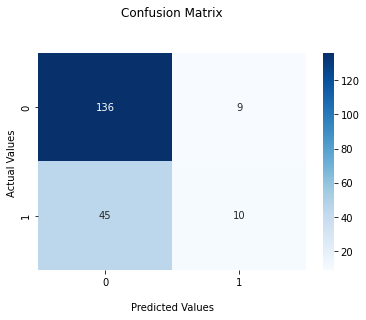

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Func to wrap up running these selected classification learners...
# NOTE: to test the performance of the learners out-of-sample, we should use a cross-validation dataset
# this is a hold back dataset and we will use our testing data to do this, in this case. 
def auto_classifier_selection(X_train: pd.DataFrame, X_cross_validation: pd.DataFrame, 
                            y_train: pd.DataFrame, y_cross_validation: pd.DataFrame) -> (list, list):
    
    #Balance training data....
    # Generate SMOTE samples and use this to train
    upsampler_smote = SMOTE()
    X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.transform(X_upsampled_smote) # scale both sets:
    X_cross_validation = sclr.transform(X_cross_validation)
    
    # initialise all the models to run
    dtc = DecisionTreeClassifier(max_depth=5) #If we allow endless depth we overfit
    gnb = GaussianNB()
    lr = LogisticRegression(max_iter=2000,random_state=0)
    mlp = MLPClassifier(max_iter=2000,random_state=1, early_stopping=True) # MLP will tend to overfit unless we stop early   
    rf = RandomForestClassifier(max_depth=3,random_state=0)
    lda = LinearDiscriminantAnalysis()
    
    # store all the models in a list
    all_mdls = [dtc,gnb,lr,mlp,rf, lda]
    
    #Find the best
    max_recall = 0
    for mdl in all_mdls:
        #Fit model
        mdl.fit(X_upsampled_smote,y_upsampled_smote)
        y_train_hat = mdl.predict(X_upsampled_smote)
        y_cross_validation_hat = mdl.predict(X_cross_validation)       
        
        # Output model selection information....
        print(mdl)
        print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, Recall cross-validation: ",
        f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}\n")
        
        #F1...
        this_recall = recall_score(y_upsampled_smote,y_train_hat, average=None)[1]
        if this_recall > max_recall:
            max_precision = this_recall
            max_mdl = mdl
        
    # The best....
    #Fit...
    max_mdl.fit(X_upsampled_smote,y_upsampled_smote)
    y_train_hat = max_mdl.predict(X_upsampled_smote)
    y_cross_validation_hat = max_mdl.predict(X_cross_validation)
    
    #    Print score
    print('\nWinner:')  
    print(max_mdl, '\n')      
    print(f"Accuracy train: {max_mdl.score(X_train,y_upsampled_smote):.4f}, Accuracy cross-validation: ",
      f"{max_mdl.score(X_cross_validation,y_cross_validation):.4f}")
    print(f"Precision train: {precision_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, Precision cross-validation: ",
      f"{precision_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_upsampled_smote, y_train_hat, average=None)[0]:.4f}, Recall cross-validation: ",
      f"{recall_score(y_cross_validation,y_cross_validation_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_upsampled_smote, y_train_hat, average=None)[1]:.4f}, F1 cross-validation: ",
      f"{f1_score(y_cross_validation,y_cross_validation_hat, average=None)[1]:.4f}", '\n')
        
    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_cross_validation, y_cross_validation_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float')

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()
    
    return max_mdl, all_mdls

#Run our function....autoselect the best classifier wrt F1
max_mdl, all_models = auto_classifier_selection(X_train, X_cross_validation, y_train, y_cross_validation)

# Exercise 4
Install and run Auto-Sklearn on our problem.  
Note: Some packages only work on certan operating systems (or containers).  Auto-SkLearn is an example, where it only runs on LINUX, the backend for Google Colab. It will not install on Windows (but it is possible to run a LINUX container on Windows).

In [ ]:
# install the required packages
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

# import the module 
import autosklearn.classification

In [ ]:
from autosklearn.pipeline.components.feature_preprocessing import FeaturePreprocessorChoice

#print the available preprocessing choices:
print('Preprocessing choices:\n')
for component in FeaturePreprocessorChoice.get_components():
    print(component)

#print the available classification models:
print('\nClassification models:\n')
from autosklearn.pipeline.components.classification import ClassifierChoice
for classifier in ClassifierChoice.get_components():
    print(classifier)

Preprocessing choices:

densifier
extra_trees_preproc_for_classification
extra_trees_preproc_for_regression
fast_ica
feature_agglomeration
kernel_pca
kitchen_sinks
liblinear_svc_preprocessor
no_preprocessing
nystroem_sampler
pca
polynomial
random_trees_embedding
select_percentile_classification
select_percentile_regression
select_rates_classification
select_rates_regression
truncatedSVD

Classification models:

adaboost
bernoulli_nb
decision_tree
extra_trees
gaussian_nb
gradient_boosting
k_nearest_neighbors
lda
liblinear_svc
libsvm_svc
mlp
multinomial_nb
passive_aggressive
qda
random_forest
sgd


# Exercises 5
Produce the AutoML leaderboard of pre-processing options and learners the AutoML has found. 

Now we will pass in our training data, and get the AutoML to construct our entire modelling pipeline from scratch. This **TAKES A LONG TIME** to run....

In [ ]:
#AutoML.... for classification
start_time = time.time()
automl_mod = autosklearn.classification.AutoSklearnClassifier()
automl_mod.fit(X_train, y_train)

print(f"It took {(time.time() - start_time):.3f} seconds to construct our modelling pipeline.")

It took 3598.519 seconds to construct our modelling pipeline.


Now the task has run, show the leaderboard of the best performing pipelines the AutoML has found and tested: preprocessors, learners and other model specifications. Also note that the AutoML has found an ensemble of different, diverse learners, aiming to benefit from stabilising ensemble effects.

In [ ]:
automl_mod.leaderboard(detailed = True, ensemble_only=False)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
262,1,0.02,libsvm_svc,0.134328,2.266594,261,0.022059,0,1.663362e+09,1.663362e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Local Search
270,2,0.02,libsvm_svc,0.138060,2.276109,269,0.031250,0,1.663362e+09,1.663362e+09,0.0,StatusType.SUCCESS,[],[fast_ica],weighting,Local Search
265,3,0.00,libsvm_svc,0.138060,19.598423,264,0.053309,0,1.663362e+09,1.663362e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Local Search
125,4,0.02,libsvm_svc,0.145522,2.030389,124,0.068015,0,1.663361e+09,1.663361e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Local Search
283,5,0.02,libsvm_svc,0.149254,2.061415,282,0.005515,0,1.663363e+09,1.663363e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Local Search
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,277,0.00,libsvm_svc,0.824627,1.894459,213,0.856618,0,1.663362e+09,1.663362e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Local Search
44,278,0.00,libsvm_svc,0.824627,0.996834,43,0.841912,0,1.663360e+09,1.663360e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Random Search (sorted)
130,279,0.00,libsvm_svc,0.824627,1.331816,129,0.834559,0,1.663361e+09,1.663361e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Local Search


In [ ]:
# output the  the best model
automl_mod.leaderboard(top_k = 1)

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
262,1,0.02,libsvm_svc,0.134328,2.266594


# Exercise 6
Calculate the F1 score for the AutoML pipeline. 

In [ ]:
# predict on training set 
y_train_hat = automl_mod.predict(X_train)
# predict on validation set 
y_validation_hat = automl_mod.predict(X_cross_validation)
# predict on test set
y_test_hat = automl_mod.predict(X_test)

In [ ]:
# Output model selection information....
print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, validation:",
      f"{f1_score(y_cross_validation, y_validation_hat, average=None)[1]:.4f}, test: "
      f"{f1_score(y_test, y_test_hat, average=None)[1]:.4f}")

F1 train: 0.9316, validation: 0.5536, test: 0.4138


The AutoML pipeline generated F1 scores on training and validation higher than our best model (Decision Tree), we previously built. <br>
**Note:** the model performs significantly better on training than on validating and testing, suggesting it may be overfitting the training data. <br> In a practical setting it would be worth trying to fine-tune the model and see whether if we can obtain better results on the validation and ultimately on the test set.  